# stat 128 final project 
## by Austin Wilson and Mark Cortez
- dataset from kaggle competition: https://www.kaggle.com/techsash/waste-classification-data
- there are two classes 
    - O stands for organic waste    
    - R stands for recyclable waste
- the purpose of this notebook
    - is to load this data into memory as a numpy array of 64 floating point numbers 
    - use the data to train a neural network to classify images as R or O 


In [1]:
import pandas as pd 
import numpy as np 
import os
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50

In [32]:
# setting up the paths that will be used for importing the data
path_train = 'DATASET/TRAIN' 
path_test = 'DATASET/TEST'
path_to_model = 'models/'

## example of one organic waste image

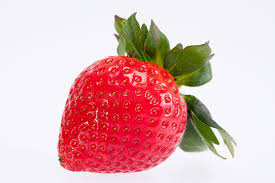

In [3]:
Image.open(path_train + "/O/O_10.jpg")

## example of one recyclable waste image

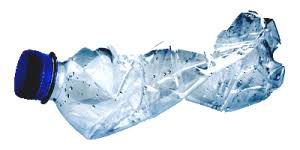

In [4]:
Image.open(path_train + "/R/R_10.jpg")

## this is a function that will convert all images to format that keras Sequential model can process
- the input path specifies the path to the data set which we will pass seperately for train and test data
- the input img_size is default 128 x 128 pixels, we did not modify this as to improve computation time
- the first two lines of the function will store all of the image names in a list to be traversed later
- the second two lines are the array that we will use to store the image data once converted into numerical format
- the for loops do the same thing for the organic images and recyclable images, respectively
    - the for loop loops through all images in the directory and converts them to numpy array and then stores them in the associated list
    - note that the command '.convert("RGB")' is to correct an error that occured from some images in greyscale 
    - note that 'if img.size == (128,128)' is just to ensure that all images were properly resized 

In [5]:
def get_numpy_image_array(path, img_size = (128,128)):
    image_names_o = os.listdir(path + "/O")
    image_names_r = os.listdir(path + "/R")
    numpy_img_array_o = []
    numpy_img_array_r = []

    # for the images in O category 
    for img_name in image_names_o:
        # some images in grey scale
        img = Image.open(path + "/O/" + img_name).convert("RGB")
        img = img.resize(img_size)
        img_array = np.asarray(img)
        if img.size == (128,128):
            numpy_img_array_o.append(img_array)

    # for the images in R category 
    for img_name in image_names_r:
        # some images in grey scale
        img = Image.open(path + "/R/" + img_name).convert("RGB")
        img = img.resize(img_size)
        img_array = np.asarray(img)
        if img.size == (128,128):
            numpy_img_array_r.append(img_array)



    return np.asarray(numpy_img_array_o, dtype="float64"), np.asarray(numpy_img_array_r, dtype="float64")

## getting images into a numpy array for training/test and organic/recycle
- first we will use the above function to convert all the images for organic/recycle test/train data into seperate numpy arrays
- then we will concatenate the organic and recyclable images into 2 numpy arrays for test and training data

In [6]:

organic_images_train, recyclable_images_train = get_numpy_image_array(path_train)
organic_images_test, recyclable_images_test = get_numpy_image_array(path_test)

In [7]:
x_train = np.concatenate([organic_images_train,recyclable_images_train])
x_test = np.concatenate([organic_images_test,recyclable_images_test])

## building the associated set of labels for x_train and x_test
- next we need to create and array of the associated labels for organic/recycle train/test images 
    - we do this by repeating the label the number of times that matches the array length
- then we concatenate the recycle and organic images for seperate train/test sets so that we have one array for each set

In [8]:
y_organic_train = np.repeat("O",len(organic_images_train))
y_recycle_train = np.repeat("R",len(recyclable_images_train))


In [9]:
y_organic_test = np.repeat("O",len(organic_images_test))
y_recycle_test = np.repeat("R",len(recyclable_images_test))

In [10]:
y_train = np.concatenate([y_organic_train,y_recycle_train])
y_test = np.concatenate([y_organic_test,y_recycle_test])

## creating label encoder for the values of O and R 
- not sure if I need two label encoders but just to be safe I created two 
- the label encoder will encode the labels "O" and "R" into numbers so that the model can make sense of them

In [11]:
le_1 = LabelEncoder()
y_train = le_1.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train)

le_2 = LabelEncoder()
y_test = le_2.fit_transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test)



## normalize the data
- we tried and failed because of memory issues 

In [107]:
# x_train = x_train / 255
# x_test = x_test / 255

## confirm size of all sets
- the first number in the tuple x_train and y_train should match, this represents the number of images the data is being trained on
- likewise for x_test and y_test we should see the same number in the first element of those tuples 
- the numbers 128,128,3 represent the dimension of each image 
- so for each x set (train/test) we have a 4d numpy array 
    - the first dimension is the number of images
    - the second dimension represents the number of pixels on the vertical axis
    - the third dimension represents the number of pixels on the horizontal axis
    - the fourth dimension represents color where 3 is red, green, blue color scale
- for each y set (train/test) we have a 2d numpy array
    - the first number represents the number of rows or the number of images being trained/tested resepctively
    - the second dimension represents the number of categories where 2 indicates that we have 2 categories "O" = organic, "R" = recycle 

In [13]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(22564, 128, 128, 3)
(22564, 2)
(2513, 128, 128, 3)
(2513, 2)


## simple model with one hidden layer
- this is the simplest model I will use just to ensure that the data is working
- first we have a Sequential model which means that each layer will directly feed into the next 
- next we have a dense layer with 32 nodes
    - this means that the input is connected to each of the 32 nodes in the first hidden layer 
    - next we have a flatten layer which converts a multi dimensional layer into a 1d layer 
    - now the last layer is a dense layer with 2 nodes and activation softmax
        - this means that we have 2 categories we are predicting and it should be a probability distribution 
- finally we compile the model using categorical crossentropy because we are doing classification
- we will also use early stopping to prevent overtraining 
- the checkpointer will save the model to a hdf5 file in case we want to directly load the trained weights into a model later

In [14]:
model_name = "simple_model.hdf5"
model_simple = Sequential()
model_simple.add(Dense(32,input_shape=(128,128,3),activation='relu'))
model_simple.add(Flatten())
model_simple.add(Dense(2,activation='softmax'))
model_simple.compile(loss='categorical_crossentropy',optimizer='adam')

In [15]:
# early stopping and checkpoint to save model weights

monitor = EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=2,verbose=2,mode='auto')
checkpointer = ModelCheckpoint(filepath=path_to_model+model_name,verbose=0,save_best_only=True)


In [16]:
# training!!
#for i in range(5):
model_simple.fit(x_train ,y_train,
                batch_size = 20,
                epochs = 20,
                verbose=2,
                callbacks=[monitor, checkpointer],
                validation_data=(x_test,y_test))



Epoch 1/20
1129/1129 - 13s - loss: 318.4380 - val_loss: 33.0742
Epoch 2/20
1129/1129 - 11s - loss: 20.9243 - val_loss: 14.0286
Epoch 3/20
1129/1129 - 11s - loss: 6.7148 - val_loss: 9.3611
Epoch 4/20
1129/1129 - 11s - loss: 2.5128 - val_loss: 4.6934
Epoch 5/20
1129/1129 - 11s - loss: 1.1025 - val_loss: 2.1599
Epoch 6/20
1129/1129 - 11s - loss: 1.3346 - val_loss: 4.7574
Epoch 7/20
1129/1129 - 11s - loss: 0.9754 - val_loss: 1.3533
Epoch 8/20
1129/1129 - 11s - loss: 0.6730 - val_loss: 1.4310
Epoch 9/20
1129/1129 - 11s - loss: 0.6511 - val_loss: 1.5259
Epoch 00009: early stopping


## predictions
- first we use argmax to get the location of the correct classifications
- then we use the trained model to predict the test set
- then the again use argmax to find the location of the predictions
- using the predicted and actual values, we calculate the f1 score and generate a classification report below

In [17]:
y_true = np.argmax(y_test,axis = 1)
y_pred1 = model_simple.predict(x_test)
y_pred1 = np.argmax(y_pred1,axis = 1)

In [20]:
f1_simple = metrics.f1_score(y_true,y_pred1,average='weighted')
print("F1 score:" + str(f1_simple))

F1 score:0.4641893819010018


this is a very poor f1 score so we will try and use transfer learning to improve

In [22]:
report = metrics.classification_report(y_true,y_pred1)
print(report)

              precision    recall  f1-score   support

           0       0.57      0.94      0.71      1401
           1       0.56      0.09      0.16      1112

    accuracy                           0.57      2513
   macro avg       0.57      0.52      0.43      2513
weighted avg       0.57      0.57      0.46      2513



## VGG16
- VGG16 is a pretrained image classification model from oxford (VGG19 is a similar model)
- first we initialize the model 
- then create our own sequential model
- next wee add all the layers from the pre-trained VGG-16 model and set trainable to false
- finally we add the flatten layer and the 2 node dense layer to make our predictions
- the rest is synonomous with the previous model 
- note that I am using a for loop here to avoid local maximum in training  
 - if we re-initialize the model in a random weights then we may be able to avoid a local max 

In [23]:
vgg16 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

model_16 = Sequential()
for layer in vgg16.layers:
  model_16.add(layer)
for layer in model_16.layers:
  layer.trainable = False


model_16.add(Flatten())
model_16.add(Dense(2,activation='softmax'))


In [24]:
checkpointer_vgg16 = ModelCheckpoint(filepath=path_to_model + 'vgg16.hdf5',verbose=0,save_best_only=True)
monitor = EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=2,verbose=2,mode='auto')
model_16.compile(optimizer='adam',loss='categorical_crossentropy')

In [25]:


for i in range(5):
    model_16.fit(x_train,y_train,
                batch_size=32,
                epochs=20,
                verbose=2,
                callbacks=[monitor,checkpointer_vgg16],
                validation_data=(x_test,y_test))


Epoch 1/20
706/706 - 46s - loss: 3.4771 - val_loss: 4.8257
Epoch 2/20
706/706 - 37s - loss: 2.7635 - val_loss: 4.3675
Epoch 3/20
706/706 - 37s - loss: 2.3708 - val_loss: 5.2162
Epoch 4/20
706/706 - 37s - loss: 2.1047 - val_loss: 7.0709
Epoch 00004: early stopping
Epoch 1/20
706/706 - 40s - loss: 2.1494 - val_loss: 6.0193
Epoch 2/20
706/706 - 36s - loss: 1.8625 - val_loss: 8.7697
Epoch 3/20
706/706 - 36s - loss: 1.7826 - val_loss: 9.0468
Epoch 00003: early stopping
Epoch 1/20
706/706 - 39s - loss: 1.6292 - val_loss: 8.4900
Epoch 2/20
706/706 - 36s - loss: 1.6617 - val_loss: 7.7333
Epoch 3/20
706/706 - 36s - loss: 1.4783 - val_loss: 9.1116
Epoch 4/20
706/706 - 37s - loss: 1.4669 - val_loss: 8.2354
Epoch 00004: early stopping
Epoch 1/20
706/706 - 41s - loss: 1.4112 - val_loss: 9.5716
Epoch 2/20
706/706 - 36s - loss: 1.2331 - val_loss: 11.6843
Epoch 3/20
706/706 - 36s - loss: 1.2956 - val_loss: 8.9080
Epoch 4/20
706/706 - 36s - loss: 1.3168 - val_loss: 11.3336
Epoch 5/20
706/706 - 37s - lo

In [27]:
y_true = np.argmax(y_test,axis = 1)
y_pred16 = model_16.predict(x_test)
y_pred16 = np.argmax(y_pred16,axis = 1)
f1_vgg16 = metrics.f1_score(y_true,y_pred16,average="weighted")
report16 = metrics.classification_report(y_true,y_pred16)

In [28]:
print("F1 score:" + str(f1_vgg16))
print(report16)

F1 score:0.8569489274841248
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1401
           1       0.89      0.78      0.83      1112

    accuracy                           0.86      2513
   macro avg       0.86      0.85      0.85      2513
weighted avg       0.86      0.86      0.86      2513



In [33]:
model_16.save_weights(path_to_model + "model.hdf5")

## VGG19
- VGG19 is a larger neural network (more hidden layers) than VGG16 but has very similar architechture and performance 

In [34]:
vgg19_128 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

model_19_128 = Sequential()
for layer in vgg19_128.layers:
  model_19_128.add(layer)
for layer in model_19_128.layers:
  layer.trainable = False


model_19_128.add(Flatten())
model_19_128.add(Dense(2,activation='softmax'))






In [35]:
checkpointer_vgg19_128 = ModelCheckpoint(filepath=path_to_model + 'vgg19.hdf5',verbose=0,save_best_only=True)
monitor = EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=2,verbose=2,mode='auto')
model_19_128.compile(optimizer='adam',loss='categorical_crossentropy')

In [36]:


# for i in range(5):
model_19_128.fit(x_train,y_train,
            batch_size=32,
            epochs=20,
            verbose=2,
            callbacks=[monitor,checkpointer_vgg19_128],
            validation_data=(x_test,y_test))



Epoch 1/20
706/706 - 41s - loss: 3.4558 - val_loss: 4.9562
Epoch 2/20
706/706 - 37s - loss: 2.6906 - val_loss: 4.5745
Epoch 3/20
706/706 - 37s - loss: 2.4009 - val_loss: 6.6269
Epoch 4/20
706/706 - 37s - loss: 2.1638 - val_loss: 6.4249
Epoch 00004: early stopping


In [38]:
y_true = np.argmax(y_test,axis = 1)
y_pred19 = model_19_128.predict(x_test)
y_pred19 = np.argmax(y_pred19,axis = 1)
f1_vgg19 = metrics.f1_score(y_true,y_pred19,average="weighted")
report19 = metrics.classification_report(y_true,y_pred19)

In [39]:
print("F1 score:" + str(f1_vgg16))
print(report16)

F1 score:0.8569489274841248
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1401
           1       0.89      0.78      0.83      1112

    accuracy                           0.86      2513
   macro avg       0.86      0.85      0.85      2513
weighted avg       0.86      0.86      0.86      2513



## InceptionV3
- here I am using a similar process to the previous 
- first we initialize the inception model 
- then we set all the layers trainable to false 
- then we add the the layers we want to the model and compile

In [42]:
inception = InceptionV3(input_shape = (128, 128, 3), include_top = False, weights = 'imagenet')

In [44]:
for layer in inception.layers:
  layer.trainable = False


In [49]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers

x = layers.Flatten()(inception.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2, activation='softmax')(x)

inception_model = tf.keras.models.Model(inception.input, x)

inception_model.compile(optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [45]:
inception_model.add(Flatten())
inception_model.add(Dense(2,activation='softmax'))

In [50]:
checkpointer_inception = ModelCheckpoint(filepath=path_to_model + 'inception.hdf5',verbose=0,save_best_only=True)
monitor = EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=2,verbose=2,mode='auto')
inception_model.compile(optimizer='adam',loss='categorical_crossentropy')

In [51]:


for i in range(5):
    inception_model.fit(x_train,y_train,
                batch_size=32,
                epochs=20,
                verbose=2,
                callbacks=[monitor,checkpointer_inception],
                validation_data=(x_test,y_test))



Epoch 1/20
706/706 - 9s - loss: 449.7189 - val_loss: 141.2544
Epoch 2/20
706/706 - 4s - loss: 350.8280 - val_loss: 124.8170
Epoch 3/20
706/706 - 4s - loss: 421.8657 - val_loss: 882.3696
Epoch 4/20
706/706 - 4s - loss: 322.4367 - val_loss: 137.6319
Epoch 00004: early stopping
Epoch 1/20
706/706 - 8s - loss: 398.9373 - val_loss: 563.5831
Epoch 2/20
706/706 - 4s - loss: 344.1863 - val_loss: 173.9738
Epoch 3/20
706/706 - 5s - loss: 368.6749 - val_loss: 182.2785
Epoch 4/20
706/706 - 4s - loss: 319.6157 - val_loss: 324.5190
Epoch 00004: early stopping
Epoch 1/20
706/706 - 7s - loss: 371.5458 - val_loss: 224.6588
Epoch 2/20
706/706 - 5s - loss: 347.8223 - val_loss: 490.1138
Epoch 3/20
706/706 - 4s - loss: 349.7149 - val_loss: 909.5586
Epoch 00003: early stopping
Epoch 1/20
706/706 - 10s - loss: 340.1517 - val_loss: 753.7800
Epoch 2/20
706/706 - 4s - loss: 351.8704 - val_loss: 213.8646
Epoch 3/20
706/706 - 4s - loss: 299.6014 - val_loss: 2230.3044
Epoch 4/20
706/706 - 4s - loss: 342.4428 - val

In [53]:
y_true = np.argmax(y_test,axis = 1)
y_pred_inception = inception_model.predict(x_test)
y_pred_inception = np.argmax(y_pred_inception,axis = 1)
f1_inception = metrics.f1_score(y_true,y_pred_inception,average="weighted")
report_inception = metrics.classification_report(y_true,y_pred_inception)

In [54]:
print("F1 score:" + str(f1_inception))
print(report_inception)

F1 score:0.6899379572178396
              precision    recall  f1-score   support

           0       0.89      0.52      0.66      1401
           1       0.60      0.92      0.73      1112

    accuracy                           0.70      2513
   macro avg       0.75      0.72      0.69      2513
weighted avg       0.77      0.70      0.69      2513



## ResNet50
- in a similar fashion we are creating a new model based on the pretrained ResNet50 image classification model 

In [61]:
resnet_model = Sequential()
resnet_model.add(ResNet50(include_top=False, weights="imagenet", pooling="max"))
resnet_model.add(Flatten())
resnet_model.add(Dense(2,activation='softmax'))

In [62]:
checkpointer_resnet = ModelCheckpoint(filepath=path_to_model + 'resnet.hdf5',verbose=0,save_best_only=True)
monitor = EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=2,verbose=2,mode='auto')
resnet_model.compile(optimizer='adam',loss='categorical_crossentropy')

In [63]:

# for i in range(5):
resnet_model.fit(x_train,y_train,
            batch_size=32,
            epochs=20,
            verbose=2,
            callbacks=[monitor,checkpointer_resnet],
            validation_data=(x_test,y_test))

Epoch 1/20
706/706 - 96s - loss: 0.8641 - val_loss: 0.5171
Epoch 2/20
706/706 - 87s - loss: 0.6210 - val_loss: 1.8148
Epoch 3/20
706/706 - 88s - loss: 0.5413 - val_loss: 0.2797
Epoch 4/20
706/706 - 87s - loss: 0.4486 - val_loss: 10.5806
Epoch 5/20
706/706 - 87s - loss: 0.4655 - val_loss: 0.5010
Epoch 00005: early stopping


In [66]:
y_true = np.argmax(y_test,axis = 1)
y_pred_resnet = resnet_model.predict(x_test)
y_pred_resnet = np.argmax(y_pred_resnet,axis = 1)
f1_resnet = metrics.f1_score(y_true,y_pred_resnet,average="weighted")
report_resnet = metrics.classification_report(y_true,y_pred_resnet)

In [67]:
print("F1 score:" + str(f1_resnet))
print(report_resnet)

F1 score:0.7405253036384816
              precision    recall  f1-score   support

           0       0.95      0.57      0.72      1401
           1       0.64      0.96      0.77      1112

    accuracy                           0.75      2513
   macro avg       0.80      0.77      0.74      2513
weighted avg       0.81      0.75      0.74      2513



## classification examples

In [68]:
labels = ["organic", "recyclable"]


## this function will be used to predict an arbitrary image using any of our predifined models
- this function will take in a model and an image
- it will convert the image into the appropriately shaped numpy arbitrary
- it will then use the model passed in to make a prediction 
- then the predicted class will be returned using the hard coded labels array above
    - note that these classes are in the order defined by the label encoder

In [87]:
def classify(img, model):
    img = Image.open(img).convert("RGB").resize((128,128))
    img_array = np.asarray(img).reshape((1,128,128,3))
    pred = model.predict(img_array)
    pred = np.argmax(pred, axis = 1)
    return labels[pred[0]]

## These are the images we will test on all models

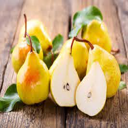

In [99]:
organic_test_img

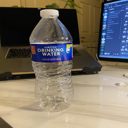

In [100]:
recycle_test_img

In [106]:
o1 = classify("O.jpg", model_simple)
r1 = classify("R.jpg", model_simple)
print("prediction for vgg16 model organic image\t: " + o1)
print("prediction for vgg16 model recyclable image\t: " + r1)

prediction for vgg16 model organic image	: organic
prediction for vgg16 model recyclable image	: organic


In [105]:
o1 = classify("O.jpg", model_16)
r1 = classify("R.jpg", model_16)
print("prediction for vgg16 model organic image\t: " + o1)
print("prediction for vgg16 model recyclable image\t: " + r1)

prediction for vgg16 model organic image	: organic
prediction for vgg16 model recyclable image	: recyclable


In [104]:
o2 = classify("O.jpg", model_19_128)
r2 = classify("R.jpg", model_19_128)
print("prediction for vgg19 model organic image\t: " + o2)
print("prediction for vgg19 model recyclable image\t: " + r2)

prediction for vgg19 model organic image	: organic
prediction for vgg19 model recyclable image	: recyclable


In [103]:
o3 = classify("O.jpg", inception_model)
r3 = classify("R.jpg", inception_model)
print("prediction for vgg19 model organic image\t: " + o3)
print("prediction for vgg19 model recyclable image\t: " + r3)

prediction for vgg19 model organic image	: organic
prediction for vgg19 model recyclable image	: recyclable


In [102]:
o4 = classify("O.jpg", resnet_model)
r4 = classify("R.jpg", resnet_model)
print("prediction for vgg19 model organic image\t: " + o4)
print("prediction for vgg19 model recyclable image\t: " + r4)

prediction for vgg19 model organic image	: organic
prediction for vgg19 model recyclable image	: recyclable
